<a href="https://colab.research.google.com/github/Deepak-Mewada/NMA-CN/blob/main/projects/neurons/load_stringer_orientations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer orientations data

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


In [ ]:
print(dat['sresp'].shape)
print(dat['xyz'].shape)
print(len(dat['istim']))


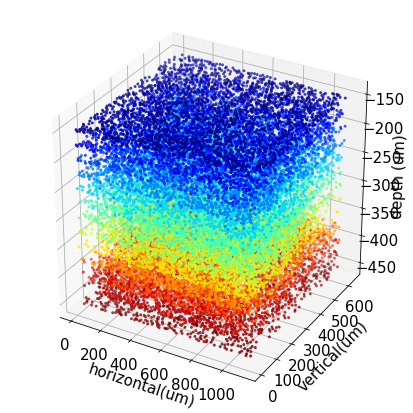

In [5]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

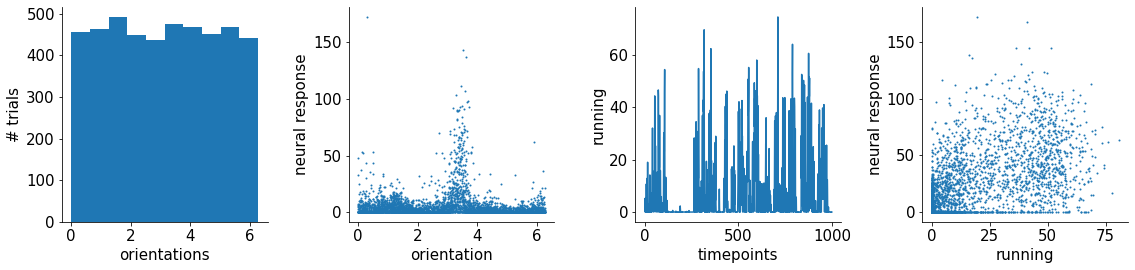

In [6]:
#@title Basic data properties using plot, hist and scatter
ax = plt.subplot(1,5,1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel = '# trials')

ax = plt.subplot(1,5,2)
plt.scatter(dat['istim'], dat['sresp'][1000], s= 1)
ax.set(xlabel = 'orientation', ylabel = 'neural response')

ax = plt.subplot(1,5,3)
plt.plot(dat['run'][:1000])
ax.set(xlabel = 'timepoints', ylabel = 'running')

ax = plt.subplot(1,5,4)
plt.scatter(dat['run'], dat['sresp'][20998], s= 1)
ax.set(xlabel = 'running', ylabel = 'neural response')

plt.show()

In [7]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
X = PCA(n_components = 200).fit_transform(Z.T)

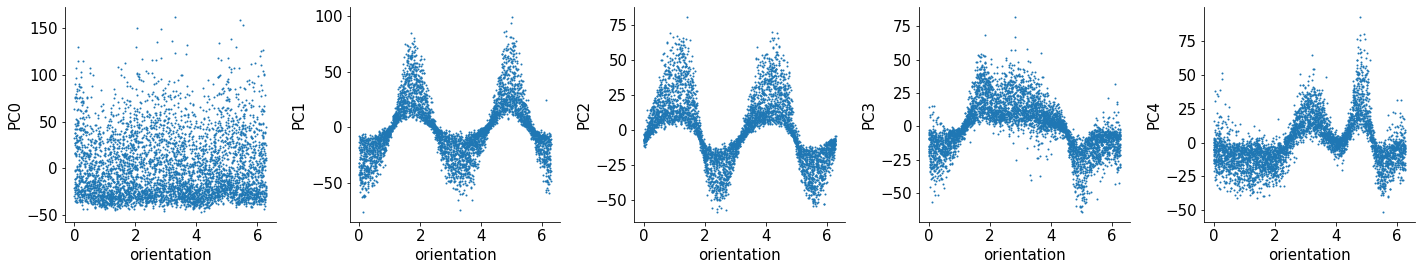

In [8]:
#@title plot PCs as function of stimulus orientation
for j in range(5):
  ax = plt.subplot(1,5,j+1)
  plt.scatter(dat['istim'], X[:,j], s = 1)
  ax.set(xlabel='orientation', ylabel = 'PC%d'%j)
plt.show()

In [9]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
!pip install umap-learn
from umap import UMAP
ncomp = 3 # try 2, then try 3
xinit = 3 * zscore(X[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 25, 
             metric = 'correlation', transform_seed = 42).fit_transform(X)

     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 1.1MB 9.5MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=fcfbd52f5660cb499a22d650fdd4b1e996ce691544a3960f01fcfe224dcff1ef
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.4-cp37-none-any.whl size=52374 sha256=1bc38f20d2827aea70f3c2577589a2057cd677ec86011cf74c35a94386f8b672
  Stored in directory: /root/.cache/pip/wheels/42/4b/8c/f6f119c67cf6583bb192431fa8f7278cf95e5b943055077d94
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


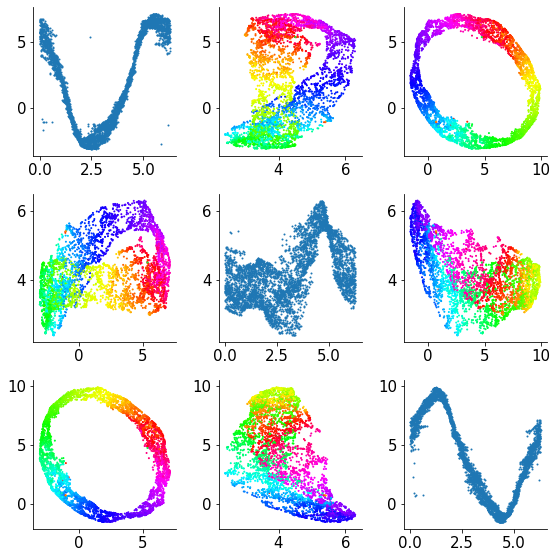

In [10]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i==j:
      plt.scatter(dat['istim'], embed[:,i], s  = 1)
    else:
      plt.scatter(embed[:,j], embed[:,i], s  = 1, c= dat['istim'], cmap = 'hsv')
# Is that a Mobius strip? A good project would be to try to figure out why (I don't know). 

##Functions

In [21]:
def calculate_orientation_selectivity( neuron_response, orientations ):
	#Arguments:
  #neuron_response: ndarray (1 x Number of stimuli) - Neuron response to each stimulus.
  #orientations: ndarray (1 x Number of stimuli) - orientation of grating in each stimuli (in radians).
	#Returns:
  #orientation_selectivity: float - the preferred orientation (in radians) this neuron.
	#Description:
  #This function takes an array of responses for a single neuron, and an array of orientations which those responses correspond to. 
  #It then calculates which orientation generates the largest response for this neuron, and returns that orientation as a scalar value.

  max_activity_index=np.argmax(neuron_response)
  orientation_selectivity=orientations[max_activity_index]

  return orientation_selectivity

def calculate_all_orientation_selectivities( neuron_responses, orientations ):
	#Arguments:
  #neuron_responses: ndarray (no. of neurons x Number of stimuli) - Neuron responses to each stimulus.
  #orientations: ndarray (1 x Number of stimuli) - orientation of grating in each stimuli (in radians).
	#Returns:
  #orientation_selectivities: array (1 x Number of neurons) - the preferred orientations (in radians) for each neuron.
	#Description:
  #This function just applies the previous function (calculate_orientation_selectivity) over an array of multiple neurons, 
  #returning the feature selectivity for each neuron.
  orientation_selectivities=[0] * len(neuron_responses)

  for i in range(len(neuron_responses)):
      orientation_selectivities[i]=calculate_orientation_selectivity(dat['sresp'][i],dat['istim'])

  return orientation_selectivities



In [74]:
calculate_all_orientation_selectivities(dat['sresp'][0:10],dat['istim'])

[0.9220944569241363,
 3.1087450017047105,
 4.302453267714099,
 1.5359120780211502,
 2.054334044408852,
 3.8424449003586316,
 1.7096108295937067,
 1.6943882555670415,
 6.028303629299025,
 2.96800987162864]

In [ ]:
def quantify_pinwheel( neuron_positions, orientation_selectivities, i, j):
	#Arguments:
  #neuron_positions: ndarray (no. of neurons x 3) - The xyz position of each neuron
  #orientation_selectivites: ndarray (1 x Number of neurons) - orientation selectivity of each neuron (in radians).
  #i: nearby neuron distance threshold
  #j: far neuron distance threshold
	
  #Returns:
  #nearby_similarity: ndarray (1 X N) orientation similarity for all pairwise neurons that are within range i of each other.
  #far_similarity: ndarray (1 X M) orientation similarity for all pairwise neurons that are greater than range j from each other.
  
  #Description:
  #This function should compare the orientation selectivities for all neurons that are within distance i of each other,
  #and return a vector of all pairwise comparison values,
  #then do the same for all neurons that are greater than distance j apart from each other.
  #The purpose of this is to then be able to compare the similarity distributions for nearby vs distant neurons.

  

return nearby_similarity,far_similarity


In [ ]:
quantify_pinwheel(dat['xyz'],)

In [81]:
print(dat['xyz'].shape)

print(dat['xyz'][:,2])

(3, 23589)
[ 342.    200.83 -150.  ]


In [79]:
print(dat['xyz'])


[[ 448.   1080.    342.   ...  221.    766.    246.  ]
 [  26.6   119.7   200.83 ...  506.73   70.49  166.25]
 [-150.   -150.   -150.   ... -450.   -450.   -450.  ]]
